<a href="https://colab.research.google.com/github/chisomrutherford/HeAR_asthma_classification/blob/main/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive and import embeddings

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

# Load embeddings and labels from Google Drive
DATA_DIR = "/content/drive/MyDrive/HeAR_Embeddings"

X_train = np.load(f"{DATA_DIR}/train_embeddings.npy")
y_train = np.load(f"{DATA_DIR}/train_labels.npy")

X_valid = np.load(f"{DATA_DIR}/valid_embeddings.npy")
y_valid = np.load(f"{DATA_DIR}/valid_labels.npy")


Mounted at /content/drive


In [2]:
# count the number of embeddings generated

total_train_embeddings = len(X_train)
total_valid_embeddings = len(X_valid)

print(f"Number of training embeddings: {total_train_embeddings}")
print(f"Number of validation embeddings: {total_valid_embeddings}")

Number of training embeddings: 5695
Number of validation embeddings: 815


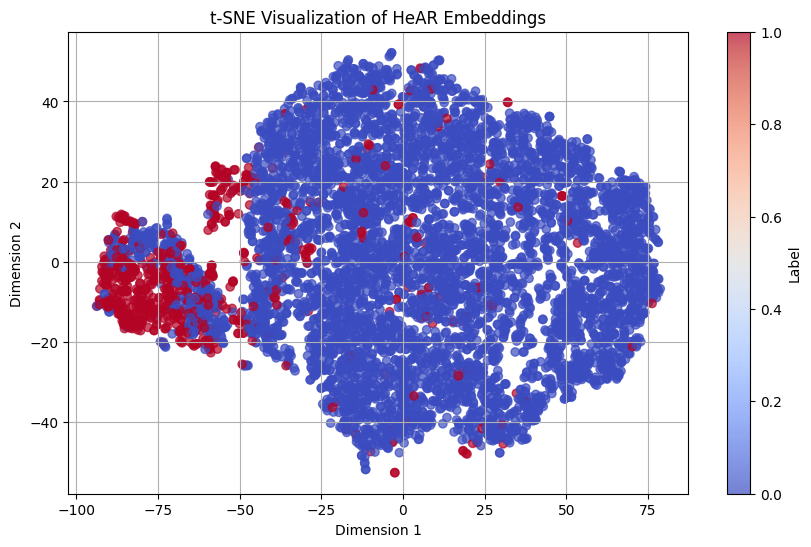

In [3]:
# t-SNE plot showing clustering of HeAR embeddings for breath sounds.
# red points indicate asthma, blue indicate normal.
# clear separation suggests meaningful representation of features.
# ? improve representation by using an event detector or manually filtering the dataset

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Combine training and validation for global view
X_all = np.vstack([X_train, X_valid])
y_all = np.hstack([y_train, y_valid])

# Reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_2d = tsne.fit_transform(X_all)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_all, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE Visualization of HeAR Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(scatter, label='Label')
plt.grid(True)
plt.show()


## Support Vector Classifier

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.svm import SVC # Import SVC

# Define a grid of C values to try
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced']
}

# Use F1 score for the asthma class (label 1) as the scoring metric
scorer = make_scorer(f1_score, pos_label=1)

# Set up grid search with 5-fold cross-validation
grid = GridSearchCV(SVC(kernel='linear', probability=True), param_grid, scoring=scorer, cv=5)
grid.fit(X_train, y_train)

# Print the best parameters found
print("Best C:", grid.best_params_['C'])
print("Best class_weight:", grid.best_params_['class_weight'])

Best C: 0.01
Best class_weight: None


In [8]:
# Use the best model to predict
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_valid)
y_prob = best_svm.predict_proba(X_valid)[:, 1]

# Evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score

print("\nClassification Report:")
print(classification_report(y_valid, y_pred))

print("AUC:", roc_auc_score(y_valid, y_prob))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       688
           1       0.93      0.82      0.87       127

    accuracy                           0.96       815
   macro avg       0.95      0.90      0.92       815
weighted avg       0.96      0.96      0.96       815

AUC: 0.9869300494414942


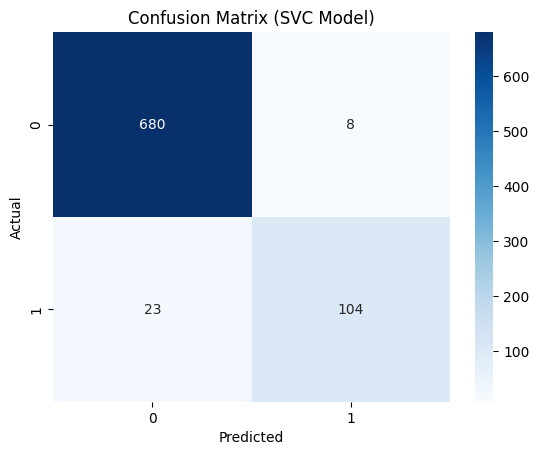

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (SVC Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Logistic Regression Model

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Define and train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [13]:
# Predict
y_pred = lr.predict(X_valid)
y_prob = lr.predict_proba(X_valid)[:, 1]


In [26]:
from sklearn.metrics import classification_report, roc_auc_score

print("Logistic Regression — Classification Report:")
print(classification_report(y_valid, y_pred))

# Compute and print AUC
auc = roc_auc_score(y_valid, y_prob)
print(f"\nLogistic Regression — AUC: {auc}")

Logistic Regression — Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       688
           1       0.90      0.80      0.85       127

    accuracy                           0.96       815
   macro avg       0.93      0.89      0.91       815
weighted avg       0.95      0.96      0.95       815


Logistic Regression — AUC: 0.9805438564365501


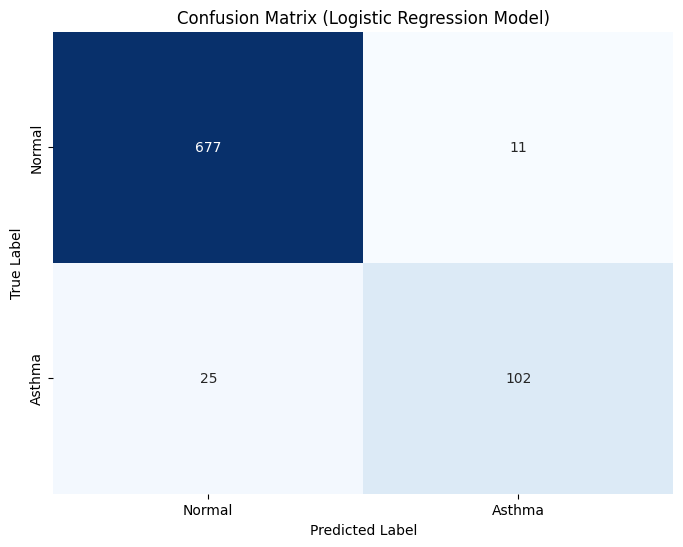

In [29]:
# Compute confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Asthma'], yticklabels=['Normal', 'Asthma'])
plt.title('Confusion Matrix (Logistic Regression Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Random Forest Model

In [3]:
from sklearn.ensemble import RandomForestClassifier

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_valid)
y_prob = rf.predict_proba(X_valid)[:, 1]


In [6]:
print("Random Forest (100 estimators) — Classification Report:\n")
print(classification_report(y_valid, y_pred, target_names=["Normal", "Abnormal"]))

auc = roc_auc_score(y_valid, y_prob)
print(f"AUC Score: {auc:.4f}")



Random Forest (100 estimators) — Classification Report:

              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97       688
    Abnormal       0.97      0.70      0.81       127

    accuracy                           0.95       815
   macro avg       0.96      0.85      0.89       815
weighted avg       0.95      0.95      0.95       815

AUC Score: 0.9789


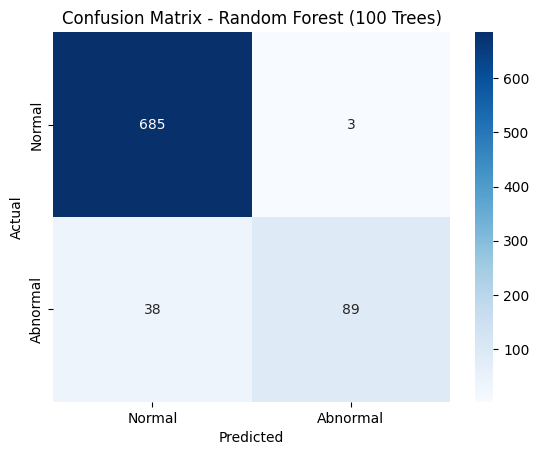

In [9]:
cm = confusion_matrix(y_valid, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.title("Confusion Matrix - Random Forest (100 Trees)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## MLP Model

In [10]:
from sklearn.neural_network import MLPClassifier

# Define and train the MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Predict
y_pred = mlp.predict(X_valid)
y_prob = mlp.predict_proba(X_valid)[:, 1]


In [11]:
print(classification_report(y_valid, y_pred))
print("AUC:", roc_auc_score(y_valid, y_prob))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       688
           1       0.89      0.91      0.90       127

    accuracy                           0.97       815
   macro avg       0.94      0.95      0.94       815
weighted avg       0.97      0.97      0.97       815

AUC: 0.9871818348287859


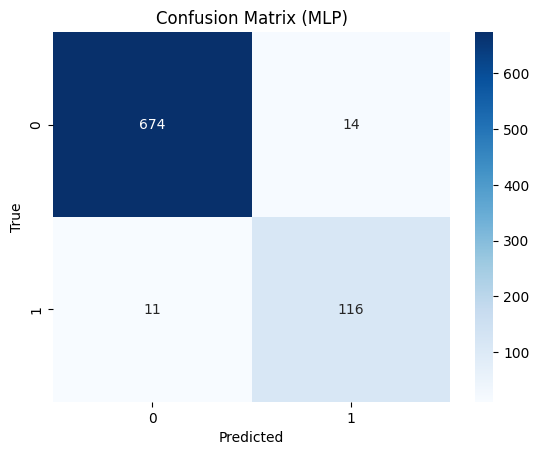

In [12]:
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (MLP)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## Save Model

In [23]:
import joblib

# Create folder in Drive to store models
!mkdir -p "/content/drive/MyDrive/HeAR_Models"

# Save the model
joblib.dump(mlp, "/content/drive/MyDrive/HeAR_Models/mlp_classifier.pkl")


['/content/drive/MyDrive/HeAR_Models/mlp_classifier.pkl']